# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.metrics import pairwise_distances
from PIL import Image
from sklearn.metrics import pairwise_distances
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

from DataSetFactory import DataSetFactory
from AMAP import AMAP

In [2]:
RANDOM_STATE = 42
SAMPLE_SIZE=0.1

In [3]:
ds = DataSetFactory.get_dataset('MNIST', sample=SAMPLE_SIZE, random_state=RANDOM_STATE)

In [4]:
X = ds.df[ds.feature_cols].values
y = ds.df[ds.label_col].values

In [5]:
X.shape

(7000, 784)

# BIRCH Threshold

In [6]:
def get_num_clusters_birch(ds, threshold):
    num_clusters = 0
    for label in ds.df[ds.label_col].unique():
        label_data = ds.df[ds.df[ds.label_col]==label][ds.feature_cols].values
        birch = Birch(threshold=threshold, branching_factor=2, n_clusters=None)
        birch.fit(label_data)
        num_clusters += birch.subcluster_centers_.shape[0]
    return num_clusters

def birch_threshold_plot(X, ds):
    dist_mat = pairwise_distances(X)
    print(dist_mat.shape)
    threshold_candidates = np.unique(dist_mat)
    print(threshold_candidates.shape)
    # for the sake of the experiment let's evaluate all of them
    thresholds_df = pd.DataFrame(threshold_candidates, columns=['threshold'])
    thresholds_df['num_clusters'] = np.nan
    thresholds_df['num_points'] = ds.df.shape[0]
    thresholds_df.hist(['threshold'])
    plt.show()
    # Filter only thresholds smaller than 1.5
#     thresholds_df_sample = thresholds_df[thresholds_df['threshold']<=0.2]
#     thresholds_df_sample = thresholds_df_sample.sample(n=200, random_state=RANDOM_STATE)
    thresholds_df_sample = thresholds_df.sample(n=200)
    
    thresholds_df_sample['num_clusters'] = thresholds_df_sample['threshold'].transform(lambda t: get_num_clusters_birch(ds, t))
    thresholds_df_sample['compression'] = thresholds_df_sample['num_points'] / thresholds_df_sample['num_clusters']
    
    sns.lineplot(x='threshold', y='compression', data=thresholds_df_sample)
    sns.lineplot(x='threshold', y='num_clusters', data=thresholds_df_sample)

(7000, 7000)
(19942204,)


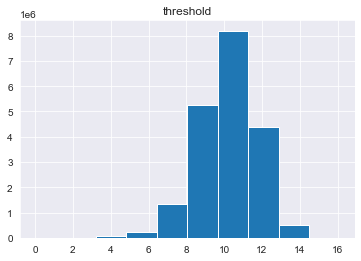

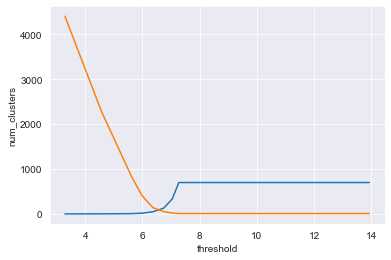

In [7]:
birch_threshold_plot(X, ds)

# UMAP

In [6]:
umap_amap = AMAP(dim_reduction_algo='umap',
            reduce_all_points=True,
            n_iter=1, 
            batch_size=0,
            learning_rate=0.1,
            do_animation=False,
            dataset='MNISTFull',
            class_to_label=ds.class_to_label,
            show_fig=True,
            save_fig=True,
            random_state=RANDOM_STATE,
            show_anchors=False,
            supervised=True,
            show_points=True,
            show_inner_blobs=False,
            show_polygons=False,
            show_label_level_plots=False,
            show_anchor_level_plot=False,
            annotate_images=False,
            birch_threshold=14)
print(umap_amap)

AMAP
addr:@fc0548
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=14
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=True
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x000001DE2EAF3558>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={8: 'Digit_8', 4: 'Digit_4', 7: 'Digit_7', 0: 'Digit_0', 6: 'Digit_6', 2: 'Digit_2', 3: 'Digit_3', 9: 'Digit_9', 5: 'Digit_5', 1: 'Digit_1'}
random_state=42
n_jobs=None
dataset='MNISTFull'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smooth_iter=13
skip_polygons_with_area=0.01
show_relations=False
mask_relation_in_same

finding intra class anchors using birch
Supervised Dim Reduction
Dim Reduction all points


C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\AppData\Local\Continuum\anaconda3_new\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^


C:\Users\omalkai\AppData\Local\Continuum\anaconda3_new\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\.

Starting iteration 1 loss = 0.7161680911680912


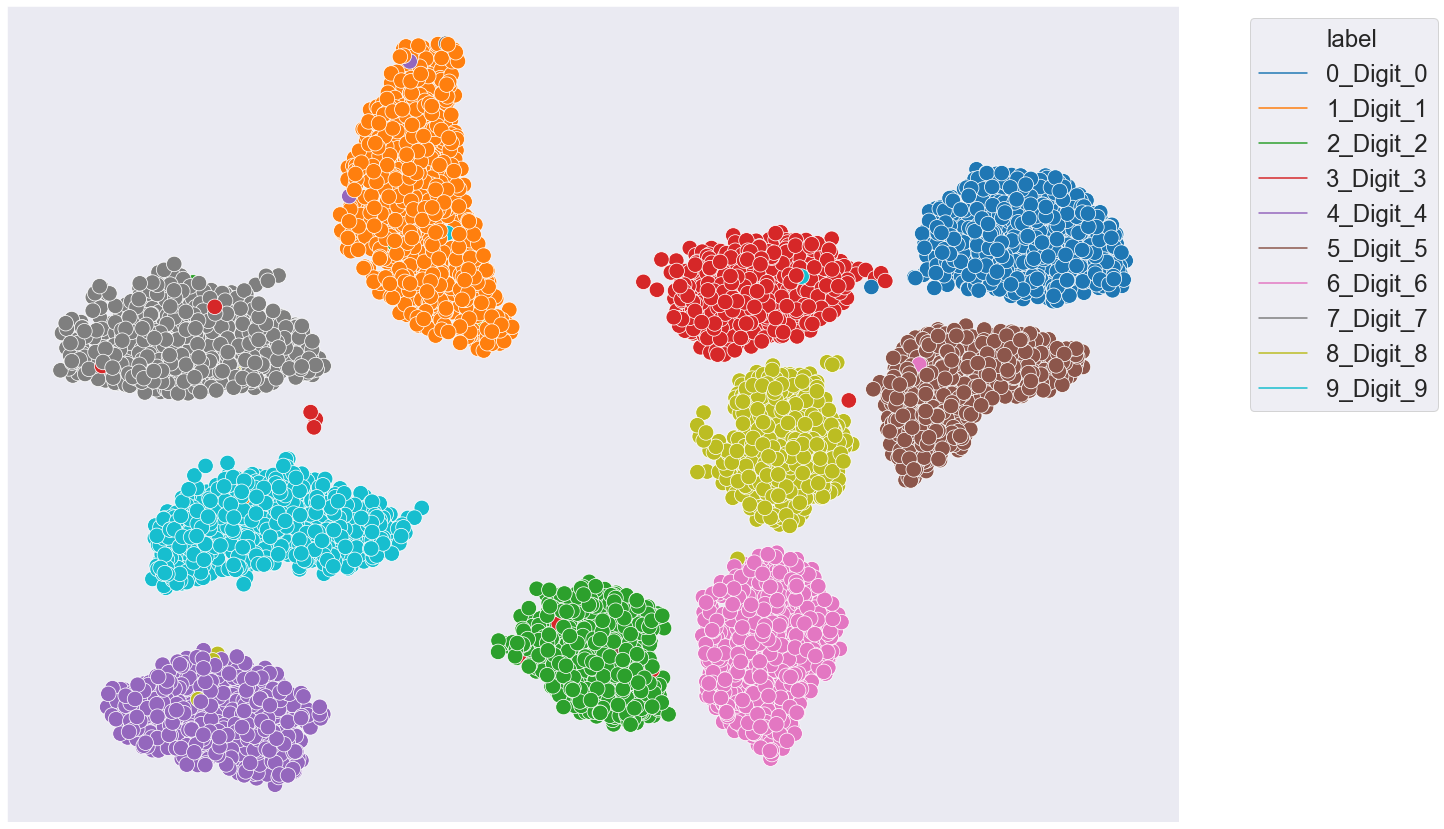

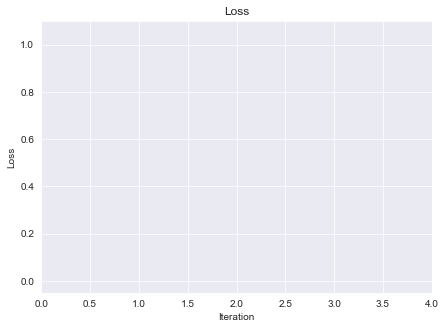

In [7]:
umap_low_dim = umap_amap.fit_transform(X, y)

# AMAP

In [8]:
blobs_amap = AMAP(reduce_all_points=False,
                  n_iter=1, 
                  batch_size=0,
                  learning_rate=0.1,
                  dataset='MNISTFull',
                  class_to_label=ds.class_to_label,
                  show_fig=True,
                  save_fig=True,
                  random_state=RANDOM_STATE,
                  show_anchors=False,
                  supervised=False,
                  show_points=False,
                  show_inner_blobs=False,
                  show_polygons=True,
                  show_label_level_plots=True,
                  show_anchor_level_plot=False,
                  save_fig_every=10,
                  annotate_images=False,
                  birch_threshold=4,
                  alpha=[
                        1.3,
                        0,
                        1,
                        1.2,
                        1.2,
                        1,
                        0.8,
                        1.2,
                        1.5,
                        1
                    ],
                  douglas_peucker_tolerance=0.8,
                  smooth_iter=3,
                  magnitude_step=False,
                  only_inter_relations=False,
                  mask_relation_in_same_label=True,
                  skip_polygons_with_area = 0.1)
print(blobs_amap)

AMAP
addr:@1e7dc8
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=4
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=False
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x000001DE2EAF3558>
loss='Linf'
only_inter_relations=False
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={8: 'Digit_8', 4: 'Digit_4', 7: 'Digit_7', 0: 'Digit_0', 6: 'Digit_6', 2: 'Digit_2', 3: 'Digit_3', 9: 'Digit_9', 5: 'Digit_5', 1: 'Digit_1'}
random_state=42
n_jobs=None
dataset='MNISTFull'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=[1.3, 0, 1, 1.2, 1.2, 1, 0.8, 1.2, 1.5, 1]
douglas_peucker_tolerance=0.8
smooth_iter=3
skip_polygons_with_area=0.1
show_

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction only anchors
Dim Reduction only anchors - generate random points in low dim per anchor


100%|█████████████████████████████████████████████████████████████████████████████| 9643/9643 [00:58<00:00, 164.20it/s]


Starting iteration 1 loss = 1.0
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719141630661127
Skipping polygon of label 2 with area 0.0001671951533239735
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.009456676898498273
Skipping polygon of label 3 with area 0.007575914162217186
Skipping polygon of label 3 with area 0.0065533509518599375
Skipping polygon of label 3 with area 0.00016719129173936587
Skipping polygon of label 3 with area 0.00016719116717212046
Sk

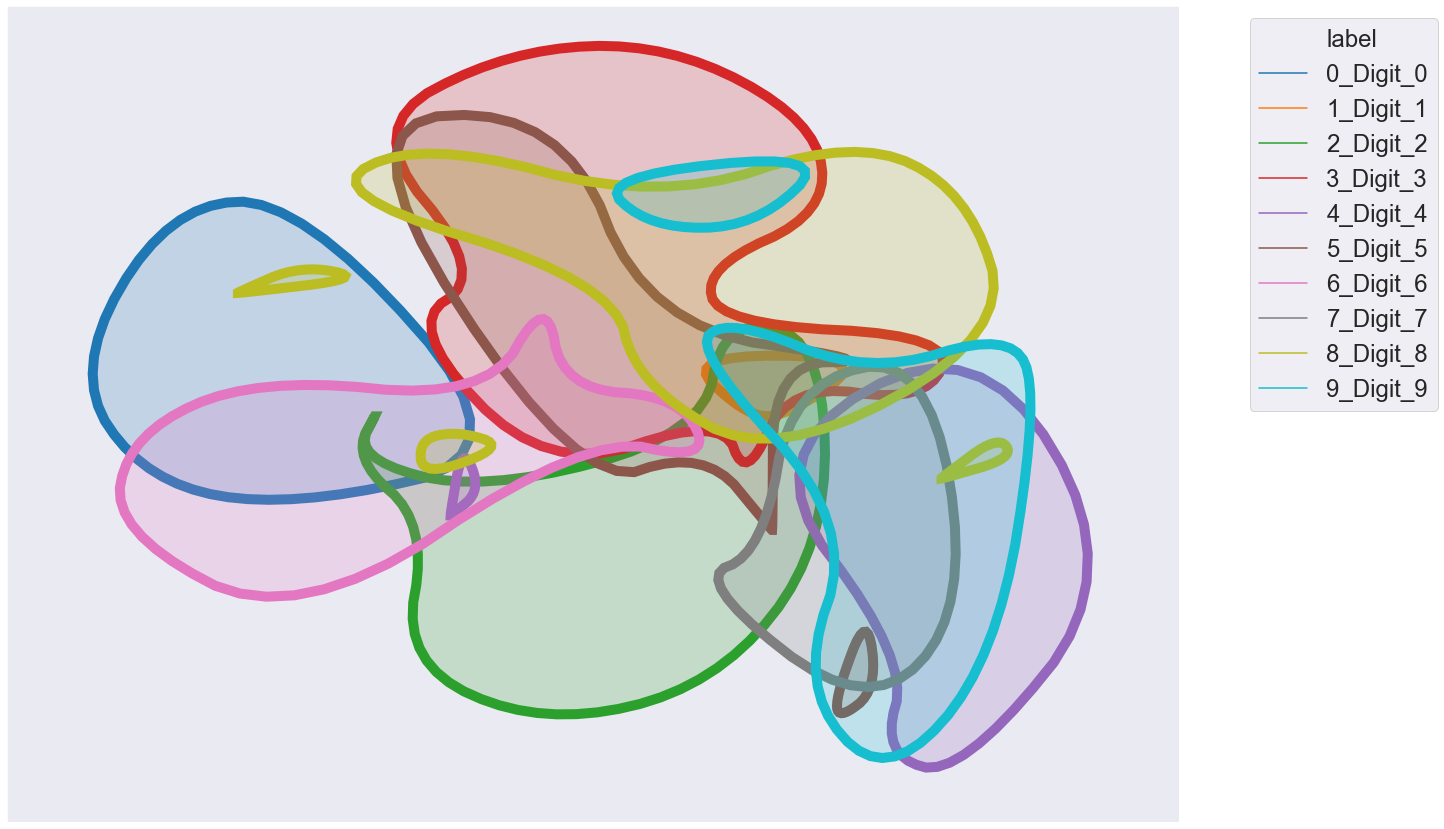

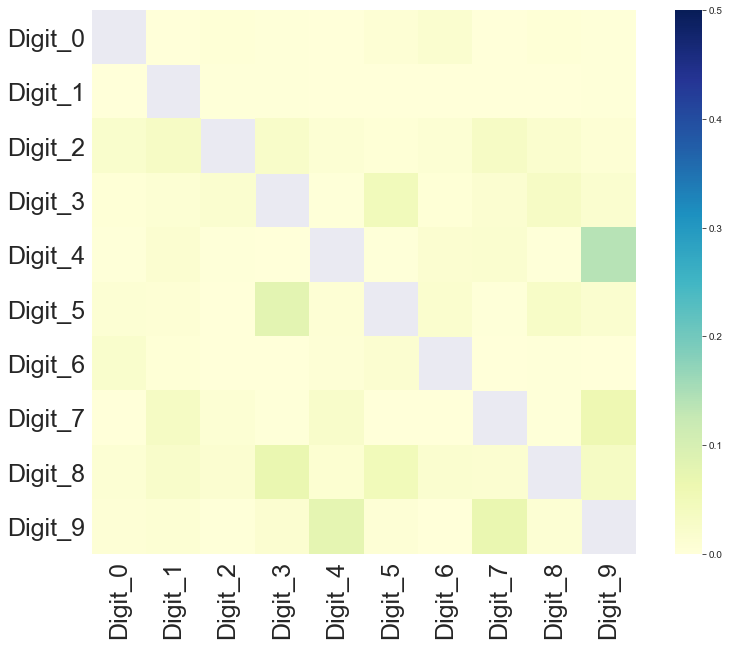

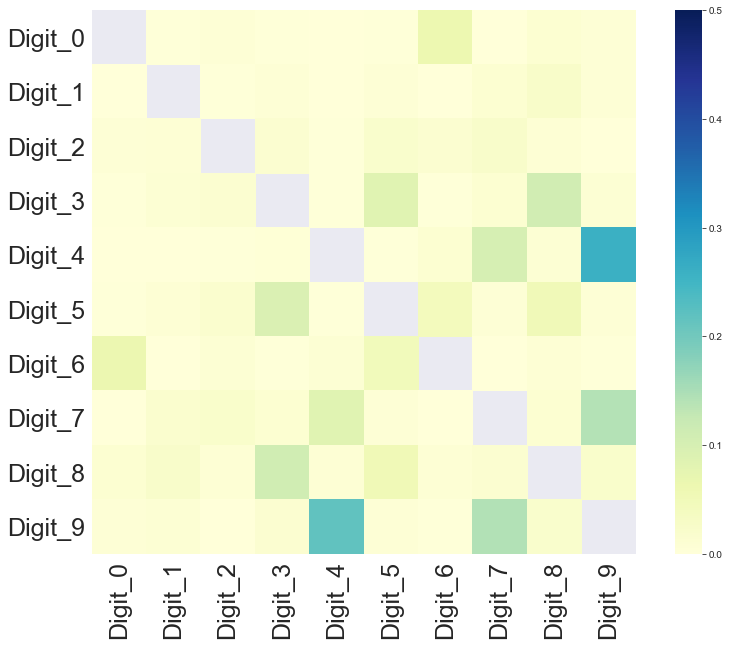

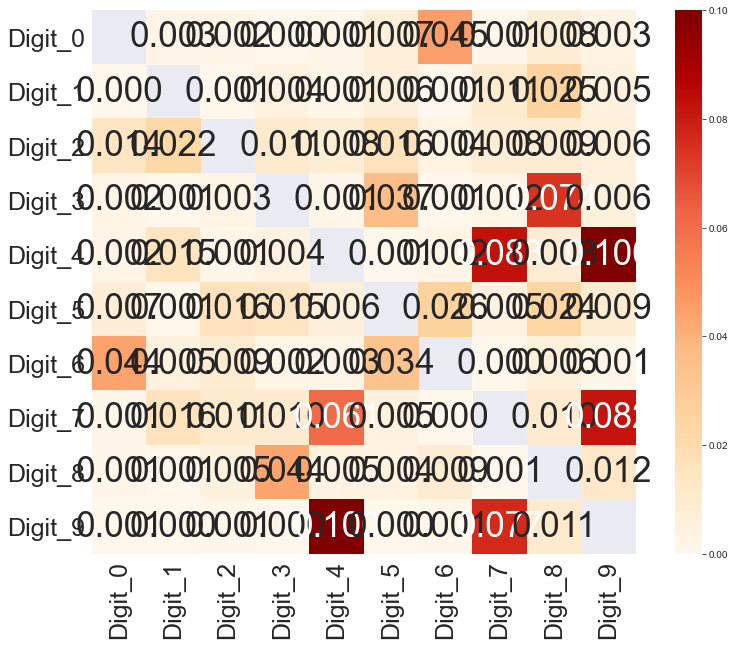

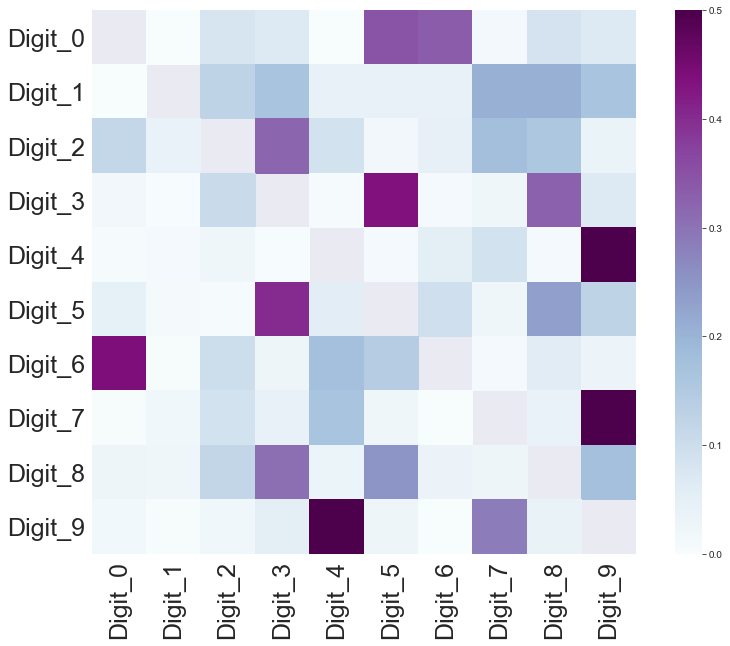

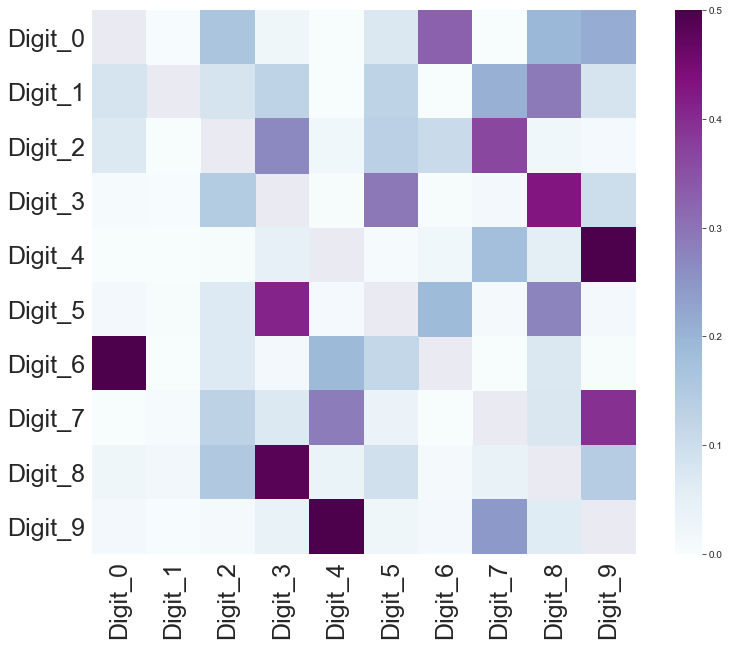

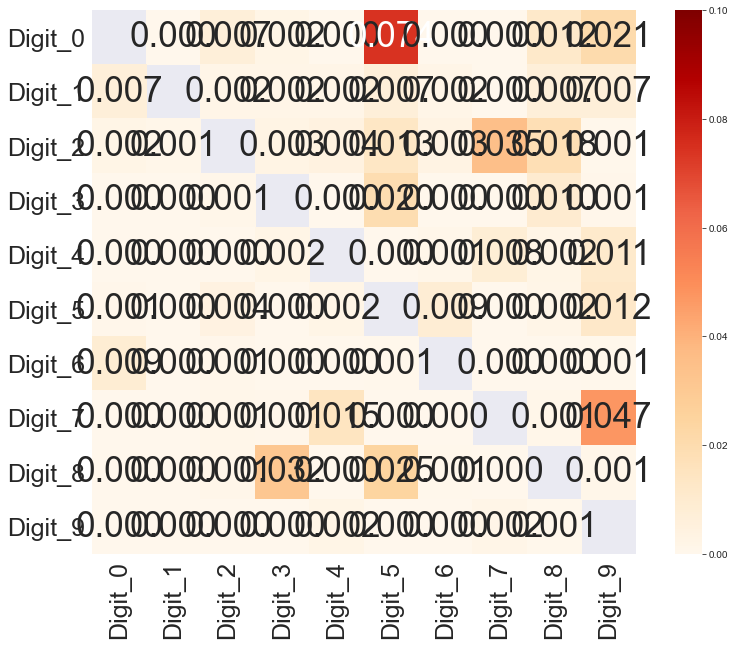

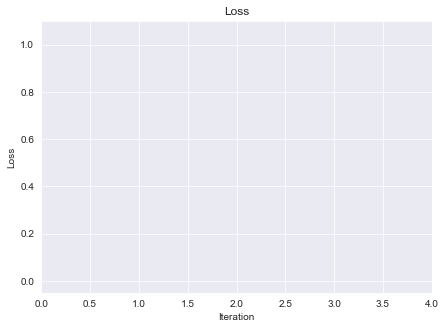

In [9]:
low_sim_blobs = blobs_amap.fit_transform(X, y)

Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 0 with area 0.0001671871811153025
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719141630661127
Skipping polygon of label 2 with area 0.0001671951533239735
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 2 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.009456676898498273
Skipping polygon of label 3 with area 0.007575914162217186
Skipping polygon of label 3 with area 0.0065533509518599375
Skipping polygon of label 3 with area 0.00016719129173936587
Skipping polygon of label 3 with area 0.00016719116717212046
Skipping polygon of label 4 with a

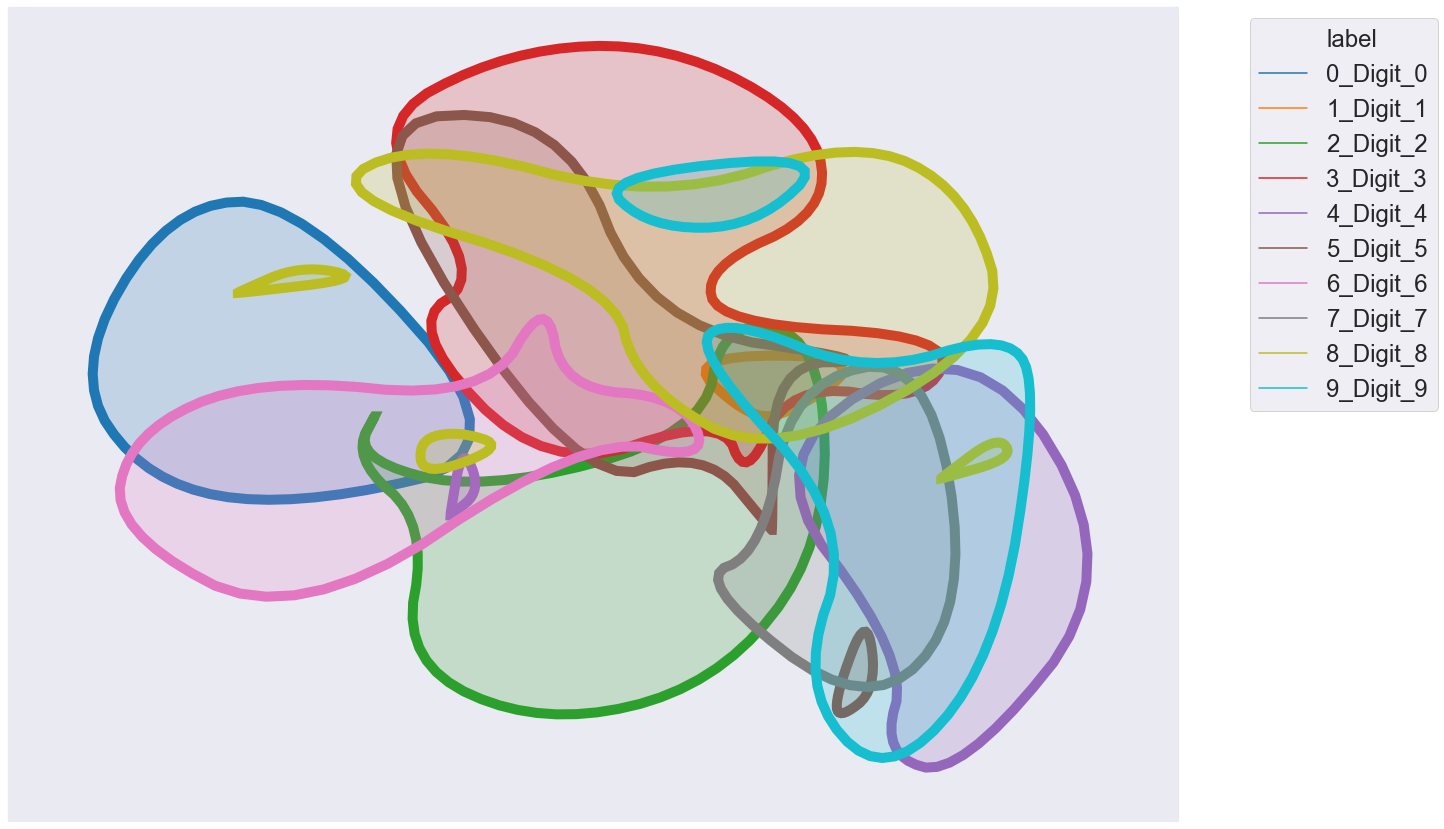

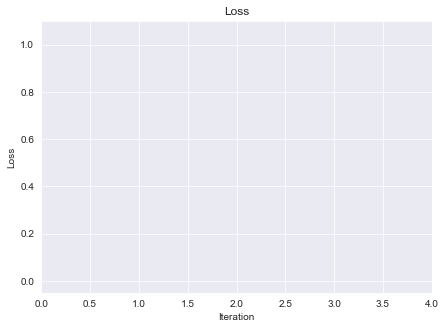

In [78]:
blobs_amap.show_anchors = False
blobs_amap.show_label_level_plots=False
blobs_amap.douglas_peucker_tolerance = 0.8
blobs_amap.skip_polygons_with_area = 0.1
blobs_amap.alpha = [
    1.3,
    0,
    1,
    1.2,
    1.2,
    1,
    0.8,
    1.2,
    1.5,
    1
]
blobs_amap.anchors_plot_sns_separate(1, True)